In [30]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import pickle # Tetap digunakan untuk MLB, LE, bins_labels, dan feature_columns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder
from sklearn.utils import class_weight
from sklearn.metrics import precision_score, recall_score, confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay, classification_report, roc_auc_score
from IPython.display import display, HTML
import os

# --- LIBRARY TENSORFLOW ---
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Input # Menambahkan Input layer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy # Untuk loss

In [31]:
# --- 1. Define Keywords ---
GENERAL_DIET_AND_HEALTH_KEYWORDS = {
    'Dietary Restrictions': [
        'vegetarian', 'vegan', 'dairy free foods', 'egg free', 'lactose free',
        'no shell fish', 'free of...'
    ],
    'Health Focus': [
        'low calorie', 'healthy', 'light', 'low cholesterol', 'low protein',
        'very low carbs', 'high fiber', 'high protein', 'protein'
    ]
}

GENERAL_COOKING_AND_EQUIPMENT_KEYWORDS = {
    'Cooking Methods': [
        'no cook', 'stove top', 'oven', 'baking', 'broil/grill', 'microwave',
        'pressure cooker', 'deep fried', 'steam', 'stir fry', 'wok'
    ],
    'Equipment': [
        'small appliance', 'mixer', 'dehydrator', 'refrigerator', 'freezer',
        'bread machine'
    ]
}

GENERAL_MEAL_AND_TIME_KEYWORDS = {
    'Meal Type': [
        'breakfast', 'brunch', 'lunchsnacks', 'one dish meal', 'stew',
        'pot roast', 'meatloaf', 'dessert', 'frozen desserts', 'ice cream',
        'cheesecake', 'bar cookie', 'drop cookies', 'chocolate chip cookies',
        'cake', 'chowders', 'clear soup', 'beef barley soup', 'mushroom soup',
        'pasta shells', 'penne', 'spaghetti', 'macaroni and cheese', 'manicotti',
        'pasta elbow', 'breads', 'quick breads', 'yeast breads',
        'sourdough breads', 'savory pies', 'pie', 'cookie & brownie',
        'beverages', 'punch beverage', 'smoothies', 'shakes', 'sauces',
        'chutneys', 'spreads', 'side dish', 'accompaniment', 'garnish',
        'coleslaw', 'potato salad'
    ],
    'Time & Budget': [
        '< 15 mins', '< 30 mins', '< 60 mins', '< 4 hours', 'weeknight',
        'inexpensive'
    ]
}

GENERAL_INGREDIENT_KEYWORDS = {
    'Proteins & Produce': [
        'chicken', 'beef', 'pork', 'duck', 'goose', 'turkey', 'veal', 'rabbit',
        'lamb/sheep', 'quail', 'deer', 'moose', 'elk', 'pheasant', 'wild game',
        'fish', 'seafood', 'salmon', 'tuna', 'halibut', 'bass', 'catfish',
        'tilapia', 'trout', 'whitefish', 'mahi mahi', 'orange roughy', 'crab',
        'lobster', 'mussels', 'oysters', 'squid', 'octopus', 'crawfish',
        'vegetable', 'soy/tofu', 'tempeh', 'cauliflower', 'artichoke',
        'onions', 'collard greens', 'spinach', 'chard', 'peppers', 'pumpkin',
        'apple', 'strawberry', 'plums', 'pineapple', 'cherries', 'berries',
        'raspberries', 'kiwifruit', 'melons', 'oranges', 'papaya', 'mango',
        'coconut', 'pear', 'lime', 'grapes', 'citrus', 'avocado', 'tropical fruits'
    ],
    'Pantry Staples': [
        'rice', 'brown rice', 'white rice', 'short grain rice',
        'medium grain rice', 'long grain rice', 'oatmeal', 'corn', 'beans',
        'black beans', 'lentil', 'peanut butter', 'cheese', 'yogurt',
        'nuts'
    ]
}

GENERAL_CULTURE_AND_FLAVOR_KEYWORDS = {
    'Regional Cuisine': [
        'chinese', 'japanese', 'thai', 'vietnamese', 'indonesian', 'korean',
        'filipino', 'cambodian', 'malaysian', 'burmese', 'singaporean',
        'laotian', 'pakistani', 'indian', 'bangladeshi', 'nepali', 'sri lankan',
        'southwest asia (middle east)', 'lebanese', 'turkish', 'iraqi',
        'iranian', 'italian', 'greek', 'french', 'german', 'scandinavian',
        'norwegian', 'swedish', 'dutch', 'austrian', 'swiss', 'welsh',
        'finnish', 'polish', 'portuguese', 'russian', 'hungarian', 'czech',
        'georgian', 'spanish', 'moroccan', 'nigerian', 'egyptian',
        'ethiopian', 'south african', 'sudanese', 'somalian', 'ghanaian',
        'kenyan', 'tanzanian', 'southern u.s.', 'southwestern u.s.',
        'native american', 'puerto rican', 'cuban', 'caribbean', 'creole',
        'cajun', 'tex mex', 'brazilian', 'argentinian', 'chilean', 'peruvian',
        'colombian', 'ecuadorean', 'venezuelan', 'guatemalan', 'costarican',
        'mexican', 'honduran', 'nicaraguan', 'salvadoran', 'panamanian',
        'bolivian', 'paraguayan', 'uruguayan', 'australian', 'new zealand',
        'polynesian', 'fijian', 'samoan', 'canadian', 'icelandic'
    ],
    'Flavor & Occasion': [
        'spicy', 'hot chili', 'cayenne', 'peppery', 'fiery', 'umami', 'savory',
        'rich', 'meaty', 'miso', 'sweet', 'sugary', 'honeyed', 'sour', 'tangy',
        'citrusy', 'vinegary', 'bitter', 'salty', 'briny', 'soy sauce',
        'christmas', 'thanksgiving', 'halloween', "st. patrick's day",
        'ramadan', 'hanukkah', 'labor day', 'memorial day', 'birthday', 'easter',
        'new year', 'spring', 'summer', 'winter', 'fall', 'potluck',
        'for large groups', 'camping', 'college food', 'beginner cook'
    ]
}

In [32]:
# --- Memuat Data Awal ---
try:
    df = pd.read_csv('../recipes_new.csv')
except FileNotFoundError:
    print("Error: 'recipes_new.csv' not found. Please ensure the file is in the correct directory.")
    exit()

pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
df.head()
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52785 entries, 0 to 52784
Data columns (total 27 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   RecipeId                    52785 non-null  int64  
 1   Name                        52785 non-null  object 
 2   AuthorId                    52785 non-null  int64  
 3   AuthorName                  52785 non-null  object 
 4   CookTime                    52785 non-null  int64  
 5   PrepTime                    52785 non-null  int64  
 6   TotalTime                   52785 non-null  int64  
 7   DatePublished               52785 non-null  object 
 8   Description                 52785 non-null  object 
 9   Images                      52785 non-null  object 
 10  RecipeCategory              52785 non-null  object 
 11  Keywords                    52785 non-null  object 
 12  RecipeIngredientQuantities  52785 non-null  object 
 13  RecipeIngredientParts       527

In [33]:
data = df.copy()

In [34]:
columns = [
    'RecipeId', 'Name', 'CookTime', 'PrepTime', 'TotalTime',
    'RecipeIngredientParts', 'Calories', 'FatContent', 'SaturatedFatContent',
    'CholesterolContent', 'SodiumContent', 'CarbohydrateContent',
    'FiberContent', 'SugarContent', 'ProteinContent', 'RecipeServings', 'Keywords',
    'Images'
]
data = data[columns]

print("Selected Data Head:")
display(data.head())
print("\nSelected Data Info:")
data.info()
print(f"Initial data shape: {data.shape}")

Selected Data Head:


,RecipeId,Name,CookTime,PrepTime,TotalTime,RecipeIngredientParts,Calories,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeServings,Keywords,Images
0,38,Low-Fat Berry Blue Frozen Dessert,1440,45,1485,"blueberries, granulated sugar, vanilla yogurt,...",171,2,1,8,30,37,4,30,3,4.0,"Dessert, Low Protein, Low Cholesterol, Healthy...",https://img.sndimg.com/food/image/upload/w_555...
1,45,Buttermilk Pie With Gingersnap Crumb Crust,50,30,80,"sugar, margarine, egg, flour, salt, buttermilk...",228,7,2,24,282,38,0,25,4,8.0,"Dessert, Healthy, Weeknight, Oven, < 4 Hours",https://img.sndimg.com/food/image/upload/w_555...
2,49,Chicken Breasts Lombardi,30,45,75,"fresh mushrooms, butter, boneless skinless chi...",628,25,13,203,849,14,1,2,58,6.0,"Chicken, Poultry, Meat, European, Very Low Car...",https://img.sndimg.com/food/image/upload/w_555...
3,56,Buttermilk Pie,60,20,80,"butter, margarine, sugar, flour, eggs, salt, v...",396,19,10,102,270,52,1,40,5,8.0,"Dessert, Oven, < 4 Hours, Easy",https://img.sndimg.com/food/image/upload/w_555...
4,58,Low-Fat Burgundy Beef & Vegetable Stew,134,30,164,"beef eye round, dried thyme leaves, salt, pepp...",280,6,2,67,592,22,6,9,30,6.0,"Vegetable, Meat, Low Cholesterol, Healthy, Fre...",https://img.sndimg.com/food/image/upload/w_555...



Selected Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52785 entries, 0 to 52784
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   RecipeId               52785 non-null  int64  
 1   Name                   52785 non-null  object 
 2   CookTime               52785 non-null  int64  
 3   PrepTime               52785 non-null  int64  
 4   TotalTime              52785 non-null  int64  
 5   RecipeIngredientParts  52785 non-null  object 
 6   Calories               52785 non-null  int64  
 7   FatContent             52785 non-null  int64  
 8   SaturatedFatContent    52785 non-null  int64  
 9   CholesterolContent     52785 non-null  int64  
 10  SodiumContent          52785 non-null  int64  
 11  CarbohydrateContent    52785 non-null  int64  
 12  FiberContent           52785 non-null  int64  
 13  SugarContent           52785 non-null  int64  
 14  ProteinContent         52785 non-

In [35]:
# --- 3.1. Preprocessing Keywords (sekarang 'tags') ---
data.rename(columns={'Keywords': 'tags'}, inplace=True)
data['tags'] = data['tags'].astype(str).apply(lambda x: re.sub(r'[^a-zA-Z, ]', '', x))
data['tags'] = data['tags'].apply(lambda x: [tag.strip() for tag in x.lower().split(',') if tag.strip()])

mlb = MultiLabelBinarizer()
tags_encoded = mlb.fit_transform(data['tags'])
tags_df = pd.DataFrame(tags_encoded, columns=mlb.classes_, index=data.index)
print(f"Number of unique keywords after binarization: {len(mlb.classes_)}")

data_processed = pd.concat([data, tags_df], axis=1)

Number of unique keywords after binarization: 267


In [36]:
# --- 3.2. Preprocessing Calories dan fitur numerik lainnya ---
data_processed.dropna(subset=['Calories'], inplace=True)
data_processed['Calories'] = data_processed['Calories'].astype(int)

bins = [0, 200, 400, 600, 800, 1000, np.inf]
labels = ['0-200', '201-400', '401-600', '601-800', '801-1000', '1000+']
data_processed['calorie_bin'] = pd.cut(data_processed['Calories'], bins=bins, labels=labels, right=True, include_lowest=True)

le = LabelEncoder()
data_processed['calorie_bin_encoded'] = le.fit_transform(data_processed['calorie_bin'])
print("Data after Calorie Binning and Encoding:")
display(data_processed[['Name', 'Calories', 'calorie_bin', 'calorie_bin_encoded']].head())
print("Calorie Bins and their Encoded Values:")
for i, label in enumerate(le.classes_):
    print(f"  {label}: {i}")

Data after Calorie Binning and Encoding:


,Name,Calories,calorie_bin,calorie_bin_encoded
0,Low-Fat Berry Blue Frozen Dessert,171,0-200,0
1,Buttermilk Pie With Gingersnap Crumb Crust,228,201-400,2
2,Chicken Breasts Lombardi,628,601-800,4
3,Buttermilk Pie,396,201-400,2
4,Low-Fat Burgundy Beef & Vegetable Stew,280,201-400,2


Calorie Bins and their Encoded Values:
  0-200: 0
  1000+: 1
  201-400: 2
  401-600: 3
  601-800: 4
  801-1000: 5


In [37]:
numerical_features = [
    'CookTime', 'PrepTime', 'TotalTime',
    'FatContent', 'SaturatedFatContent', 'CholesterolContent', 'SodiumContent',
    'CarbohydrateContent', 'FiberContent', 'SugarContent', 'ProteinContent',
    'RecipeServings'
]

for col in numerical_features:
    if col in data_processed.columns:
        data_processed[col] = pd.to_numeric(data_processed[col], errors='coerce').fillna(0)

binarized_tag_features = mlb.classes_.tolist()
feature_columns_for_X = numerical_features + binarized_tag_features

X = data_processed[feature_columns_for_X].copy()
y = data_processed['calorie_bin_encoded'].copy()

model_input_feature_columns = X.columns.tolist()
print(f"Features (X) columns for model training: {model_input_feature_columns[:5]}... ({len(model_input_feature_columns)} total)")

# Pembagian data menjadi training dan testing set
# Konversi ke NumPy array dengan tipe data yang tepat untuk TensorFlow
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_train_tf = X_train.values.astype(np.float32)
X_test_tf = X_test.values.astype(np.float32)
y_train_tf = y_train.values.astype(np.int32)
y_test_tf = y_test.values.astype(np.int32)

print(f"X_train_tf shape: {X_train_tf.shape}, y_train_tf shape: {y_train_tf.shape}")
print(f"X_test_tf shape: {X_test_tf.shape}, y_test_tf shape: {y_test_tf.shape}")

Features (X) columns for model training: ['CookTime', 'PrepTime', 'TotalTime', 'FatContent', 'SaturatedFatContent']... (279 total)
X_train_tf shape: (42228, 279), y_train_tf shape: (42228,)
X_test_tf shape: (10557, 279), y_test_tf shape: (10557,)


In [38]:
# --- MODEL TENSORFLOW SEBAGAI MODEL UTAMA ---
print("\n--- Membangun dan Melatih Model TensorFlow (MLP) ---")

# Tentukan jumlah fitur input dan jumlah kelas output
input_shape = X_train_tf.shape[1]
num_classes = len(np.unique(y_train_tf))

# Bangun model Sequential (MLP)
tf_model = Sequential([
    Input(shape=(input_shape,)), # Menggunakan Input layer eksplisit untuk clarity
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Kompilasi model
# Gunakan `SparseCategoricalCrossentropy` karena label `y` adalah integer
tf_model.compile(optimizer=Adam(learning_rate=0.001),
                 loss=SparseCategoricalCrossentropy(),
                 metrics=['accuracy'])

print("\nTensorFlow Model Summary:")
tf_model.summary()


--- Membangun dan Melatih Model TensorFlow (MLP) ---

TensorFlow Model Summary:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 128)            │        35,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,486 (173.77 KB)

 Trainable params: 44,486 (173.77 KB)

 Non-trainable params: 0 (0.00 B)

In [39]:
# Hitung bobot kelas untuk menangani ketidakseimbangan kelas (jika ada)
class_weights_array = class_weight.compute_class_weight('balanced', classes=np.unique(y_train_tf), y=y_train_tf)
class_weight_dict_tf = dict(enumerate(class_weights_array))
print("Calculated Class Weights (TensorFlow):", class_weight_dict_tf)

Calculated Class Weights (TensorFlow): {0: 0.6534818941504178, 1: 37.04210526315789, 2: 0.3855804525283515, 3: 0.7763927192498621, 4: 2.30527350147396, 5: 7.846153846153846}


In [40]:
# Latih model TensorFlow
print("\nTraining TensorFlow Model in progress...")
history = tf_model.fit(X_train_tf, y_train_tf,
                       epochs=50, # Jumlah epoch dapat disesuaikan
                       batch_size=32, # Ukuran batch dapat disesuaikan
                       validation_data=(X_test_tf, y_test_tf),
                       class_weight=class_weight_dict_tf, # Terapkan bobot kelas
                       verbose=1)

print("\nTensorFlow Model Training Complete.")


Training TensorFlow Model in progress...
Epoch 1/50
1320/1320 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.2664 - loss: 8.5385 - val_accuracy: 0.4671 - val_loss: 1.6715
Epoch 2/50
1320/1320 ━━━━━━━━━━━━━━━━━━━━ 1s 807us/step - accuracy: 0.4507 - loss: 2.4625 - val_accuracy: 0.5623 - val_loss: 1.6722
Epoch 3/50
1320/1320 ━━━━━━━━━━━━━━━━━━━━ 1s 837us/step - accuracy: 0.5520 - loss: 1.6729 - val_accuracy: 0.6679 - val_loss: 0.9089
Epoch 4/50
1320/1320 ━━━━━━━━━━━━━━━━━━━━ 1s 788us/step - accuracy: 0.6580 - loss: 1.0758 - val_accuracy: 0.6837 - val_loss: 0.8727
Epoch 5/50
1320/1320 ━━━━━━━━━━━━━━━━━━━━ 1s 791us/step - accuracy: 0.6823 - loss: 0.9765 - val_accuracy: 0.7134 - val_loss: 0.6529
Epoch 6/50
1320/1320 ━━━━━━━━━━━━━━━━━━━━ 1s 806us/step - accuracy: 0.7429 - loss: 0.7726 - val_accuracy: 0.7766 - val_loss: 0.5320
Epoch 7/50
1320/1320 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7629 - loss: 0.7331 - val_accuracy: 0.7855 - val_loss: 0.5171
Epoch 8/50
1320/1320 ━━━━━━━━━━━━━━━━━

In [41]:
# Evaluasi model TensorFlow
print("\n--- Evaluasi Model TensorFlow ---")
loss_tf, accuracy_tf = tf_model.evaluate(X_test_tf, y_test_tf, verbose=0)
print(f"Accuracy on Test Set (TensorFlow Model): {accuracy_tf:.4f}")
print(f"Loss on Test Set (TensorFlow Model): {loss_tf:.4f}")


--- Evaluasi Model TensorFlow ---
Accuracy on Test Set (TensorFlow Model): 0.9312
Loss on Test Set (TensorFlow Model): 0.1817


In [42]:
y_pred_tf = np.argmax(tf_model.predict(X_test_tf), axis=1)

print("\nClassification Report (TensorFlow):")
print(classification_report(y_test_tf, y_pred_tf, target_names=le.classes_))

330/330 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step

Classification Report (TensorFlow):
              precision    recall  f1-score   support

       0-200       0.98      0.94      0.96      2692
       1000+       0.77      0.98      0.86        48
     201-400       0.96      0.95      0.95      4563
     401-600       0.91      0.89      0.90      2266
     601-800       0.77      0.92      0.84       764
    801-1000       0.81      0.88      0.84       224

    accuracy                           0.93     10557
   macro avg       0.87      0.93      0.89     10557
weighted avg       0.93      0.93      0.93     10557




Confusion Matrix (TensorFlow):


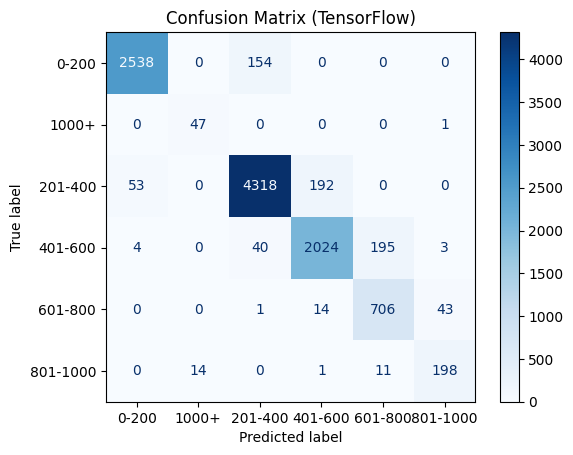

In [43]:
print("\nConfusion Matrix (TensorFlow):")
cm_tf = confusion_matrix(y_test_tf, y_pred_tf)
disp_tf = ConfusionMatrixDisplay(confusion_matrix=cm_tf, display_labels=le.classes_)
disp_tf.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix (TensorFlow)')
plt.show()


In [44]:
try:
    y_pred_proba_tf = tf_model.predict(X_test_tf) # Model TF langsung memberikan probabilitas
    roc_auc_tf = roc_auc_score(y_test_tf, y_pred_proba_tf, multi_class='ovr', average='weighted', labels=np.unique(y_test_tf))
    print(f"ROC AUC Score (weighted 'ovr', TensorFlow): {roc_auc_tf:.4f}")
except Exception as e:
    print(f"Could not calculate ROC AUC score for TensorFlow: {e}")

330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
ROC AUC Score (weighted 'ovr', TensorFlow): 0.9937


In [45]:
# --- 7. Save Model and Preprocessing Objects ---
try:
    # Simpan model TensorFlow
    tf_model.save('tensorflow_model.h5') # Simpan dalam format H5

    with open('mlb.pkl', 'wb') as f:
        pickle.dump(mlb, f)
    with open('le.pkl', 'wb') as f:
        pickle.dump(le, f)
    with open('model_input_feature_columns.pkl', 'wb') as f:
        pickle.dump(model_input_feature_columns, f)
    with open('bins_labels.pkl', 'wb') as f:
        pickle.dump({'bins': bins, 'labels': labels}, f)

    print("Model, preprocessing objects, and bin information saved successfully.")
except Exception as e:
    print(f"Error saving objects: {e}")

Model, preprocessing objects, and bin information saved successfully.


In [46]:
# --- REPLIKASI LOGIKA BEBAN MODEL UNTUK FUNGSI REKOMENDASI (Sekarang memuat TF model) ---
try:
    loaded_model = load_model('tensorflow_model.h5') # Memuat model TensorFlow
    with open('mlb.pkl', 'rb') as f:
        loaded_mlb = pickle.load(f)
    with open('le.pkl', 'rb') as f:
        loaded_le = pickle.load(f)
    with open('model_input_feature_columns.pkl', 'rb') as f:
        loaded_model_input_feature_columns = pickle.load(f)
    with open('bins_labels.pkl', 'rb') as f:
        bin_data = pickle.load(f)
        bins = bin_data['bins']
        labels = bin_data['labels']
    print("\nTensorFlow model and preprocessing objects loaded for recommendation function.")
except Exception as e:
    print(f"Error loading TensorFlow model or preprocessing objects for recommendation: {e}")
    exit() # Hentikan eksekusi jika gagal memuat


TensorFlow model and preprocessing objects loaded for recommendation function.


In [47]:
def search_food_by_keywords(df, keywords, target_calories, top_n=5):
    keywords = [k.lower() for k in keywords]
    temp_df = df.copy()
    temp_df['tags_cleaned'] = temp_df['tags'].copy()

    filtered_df = temp_df[temp_df['tags_cleaned'].apply(lambda x: any(k in x for k in keywords))].copy()

    if filtered_df.empty:
        print(f"No food found matching keywords: {keywords}")
        return pd.DataFrame(columns=['food', 'tags', 'calories', 'pred_prob'])

    target_calorie_label = None
    if target_calories <= bins[0]:
        target_calorie_label = labels[0]
    elif target_calories >= bins[-1]:
        target_calorie_label = labels[-1]
    else:
        for i in range(len(bins) - 1):
            if bins[i] < target_calories <= bins[i+1]:
                target_calorie_label = labels[i]
                break

    try:
        target_calorie_bin_encoded = loaded_le.transform([target_calorie_label])[0]
    except ValueError:
        print(f"Error: Target calorie label '{target_calorie_label}' not found in loaded LabelEncoder classes.")
        return pd.DataFrame(columns=['food', 'tags', 'calories', 'pred_prob'])

    filtered_keywords_encoded = loaded_mlb.transform(filtered_df['tags_cleaned'])
    filtered_keywords_df = pd.DataFrame(filtered_keywords_encoded, columns=loaded_mlb.classes_, index=filtered_df.index)

    X_predict = pd.DataFrame(0, index=filtered_df.index, columns=loaded_model_input_feature_columns)

    numerical_features_for_predict = [
        'CookTime', 'PrepTime', 'TotalTime',
        'FatContent', 'SaturatedFatContent', 'CholesterolContent', 'SodiumContent',
        'CarbohydrateContent', 'FiberContent', 'SugarContent', 'ProteinContent',
        'RecipeServings'
    ]

    for col in numerical_features_for_predict:
        if col in filtered_df.columns:
            X_predict[col] = pd.to_numeric(filtered_df[col], errors='coerce').fillna(0)

    for col in loaded_mlb.classes_:
        if col in loaded_model_input_feature_columns and col in filtered_keywords_df.columns:
            X_predict[col] = filtered_keywords_df[col]

    # --- PENTING: Prediksi menggunakan Model TensorFlow ---
    # Konversi X_predict ke NumPy array dengan tipe data float32
    X_predict_tf = X_predict.values.astype(np.float32)
    pred_proba = loaded_model.predict(X_predict_tf) # loaded_model sekarang adalah model TF

    if target_calorie_bin_encoded >= pred_proba.shape[1]:
        print(f"Error: Encoded target calorie bin {target_calorie_bin_encoded} is out of bounds for model's prediction probabilities (num_classes={pred_proba.shape[1]}).")
        return pd.DataFrame(columns=['food', 'tags', 'calories', 'pred_prob'])

    filtered_df['pred_prob'] = [prob[target_calorie_bin_encoded] for prob in pred_proba]

    filtered_df = filtered_df.sort_values(by='pred_prob', ascending=False)

    return filtered_df[['Name', 'tags', 'Calories', 'pred_prob']].rename(
        columns={'Name': 'food'}
    ).head(top_n)

In [48]:
print("\n--- 10. Demonstrating Recommendation Function (Using TensorFlow Model) ---")
# Contoh penggunaan 1
user_input_1 = ['high protein', 'asian', 'low calorie']
user_input_1 = [x.lower() for x in user_input_1]
target_calories_1 = 450

print(f"\nScenario 1: Keywords={user_input_1}, Target Calories={target_calories_1}")
result_1 = search_food_by_keywords(data, user_input_1, target_calories_1, top_n=5)
display(result_1)


--- 10. Demonstrating Recommendation Function (Using TensorFlow Model) ---

Scenario 1: Keywords=['high protein', 'asian', 'low calorie'], Target Calories=450
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step


,food,tags,Calories,pred_prob
51727,Easy Yellow Thai Curry,"[thai, asian, mins, easy]",480,0.996962
42825,Dave Roberts' Mac &amp; Cheese,"[high protein, high in, weeknight, mins, easy]",475,0.996929
19083,Garlic Curry Chicken &amp; Spinach,"[chicken, spinach, poultry, greens, vegetable,...",467,0.996905
15333,Coconut Chicken Curry,"[poultry, coconut, fruit, nuts, meat, asian, i...",467,0.996792
20291,The Best Biryani,"[lambsheep, poultry, rice, meat, pakistani, as...",494,0.996751


In [49]:
# Contoh dengan kata kunci yang berbeda 2
user_input_2 = ['vegetarian', 'dessert', 'chocolate chip cookies']
user_input_2 = [x.lower() for x in user_input_2]
target_calories_2 = 300
print(f"\nScenario 2: Keywords={user_input_2}, Target Calories={target_calories_2}")
result_2 = search_food_by_keywords(data, user_input_2, target_calories_2, top_n=3)
display(result_2)


Scenario 2: Keywords=['vegetarian', 'dessert', 'chocolate chip cookies'], Target Calories=300
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


,food,tags,Calories,pred_prob
24455,Cranberry Orange Sherbet,"[dessert, berries, citrus, fruit, mins]",255,0.999997
51676,Fluffy Artoulakia With Chocolate Chips (Greek ...,"[dessert, greek, european, mins]",279,0.999995
22392,Jan's French Pastry Apple Slices,"[dessert, apple, fruit, low protein, low chole...",277,0.999980


In [50]:
# Contoh 3: Resep makan malam cepat, tinggi serat
print("\n--- Skenario 3: Resep Makan Malam Cepat, Tinggi Serat (Target 650 kcal) ---")
user_input_3 = ['weeknight', 'high fiber', 'chicken']
user_input_3 = [x.lower() for x in user_input_3]
target_calories_3 = 650
result_3 = search_food_by_keywords(data, user_input_3, target_calories_3, top_n=4)
display(result_3)

print(f"\nFinal data shape used for search: {data.shape}")


--- Skenario 3: Resep Makan Malam Cepat, Tinggi Serat (Target 650 kcal) ---
284/284 ━━━━━━━━━━━━━━━━━━━━ 0s 364us/step


,food,tags,Calories,pred_prob
51333,Spaghetti With Garlic &amp; Olive Oil,"[european, weeknight, mins, easy, inexpensive]",614,0.999656
49754,Chicken and Couscous With Fennel and Orange,"[chicken breast, chicken, poultry, meat, afric...",660,0.993526
59,Fragrant Lamb Stew with Dried Fruits,"[lambsheep, fruit, meat, weeknight, oven, hours]",691,0.993491
3034,Perfect Smoked Pork,"[pork, meat, southwestern us, very low carbs, ...",673,0.993130



Final data shape used for search: (52785, 18)
